# GTFS Bus Data Analysis

This notebook analyzes NYC MTA bus GTFS data including:
1. **GTFS Schedule Data** - Static transit schedule from `data/gtfs_b/`
2. **GTFS Realtime Data** - Real-time vehicle positions from parquet files

## Part 1: GTFS Schedule Summary

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load GTFS schedule files
gtfs_path = 'data/gtfs_b/'

print("Loading GTFS Schedule Data...")
print("="*60)

# Load key GTFS files
calendar = pd.read_csv(gtfs_path + 'calendar.txt')
calendar_dates = pd.read_csv(gtfs_path + 'calendar_dates.txt')
routes = pd.read_csv(gtfs_path + 'routes.txt')
trips = pd.read_csv(gtfs_path + 'trips.txt')
stops = pd.read_csv(gtfs_path + 'stops.txt')
agency = pd.read_csv(gtfs_path + 'agency.txt')

print("✓ Loaded all GTFS files successfully")

Loading GTFS Schedule Data...
✓ Loaded all GTFS files successfully


In [2]:
# Service Date Coverage
print("\n📅 SERVICE DATE COVERAGE")
print("="*60)

# Convert date columns to datetime
calendar['start_date'] = pd.to_datetime(calendar['start_date'], format='%Y%m%d')
calendar['end_date'] = pd.to_datetime(calendar['end_date'], format='%Y%m%d')
calendar_dates['date'] = pd.to_datetime(calendar_dates['date'], format='%Y%m%d')

# Calendar (regular service patterns)
print("\nRegular Service Patterns (calendar.txt):")
print(f"  Service start: {calendar['start_date'].min().strftime('%Y-%m-%d')}")
print(f"  Service end:   {calendar['end_date'].max().strftime('%Y-%m-%d')}")
print(f"  Number of service patterns: {len(calendar)}")
print(f"\n  Service IDs by day of week:")
for idx, row in calendar.iterrows():
    days = []
    if row['monday'] == 1: days.append('Mon')
    if row['tuesday'] == 1: days.append('Tue')
    if row['wednesday'] == 1: days.append('Wed')
    if row['thursday'] == 1: days.append('Thu')
    if row['friday'] == 1: days.append('Fri')
    if row['saturday'] == 1: days.append('Sat')
    if row['sunday'] == 1: days.append('Sun')
    print(f"    {row['service_id']}: {', '.join(days)}")

# Calendar dates (exceptions)
print(f"\nService Exceptions (calendar_dates.txt):")
print(f"  Date range: {calendar_dates['date'].min().strftime('%Y-%m-%d')} to {calendar_dates['date'].max().strftime('%Y-%m-%d')}")
print(f"  Total exception dates: {len(calendar_dates)}")
print(f"  Added service (1): {(calendar_dates['exception_type'] == 1).sum()} dates")
print(f"  Removed service (2): {(calendar_dates['exception_type'] == 2).sum()} dates")

# Overall date coverage
all_dates = pd.concat([
    calendar[['start_date']].rename(columns={'start_date': 'date'}),
    calendar[['end_date']].rename(columns={'end_date': 'date'}),
    calendar_dates[['date']]
])
print(f"\n📊 OVERALL DATE RANGE: {all_dates['date'].min().strftime('%Y-%m-%d')} to {all_dates['date'].max().strftime('%Y-%m-%d')}")


📅 SERVICE DATE COVERAGE

Regular Service Patterns (calendar.txt):
  Service start: 2025-01-29
  Service end:   2025-06-28
  Number of service patterns: 29

  Service IDs by day of week:
    EN_B5-Sunday: Sun
    EN_B5-Weekday: Mon, Tue, Wed, Thu, Fri
    EN_B5-Weekday-SDon: Mon, Tue, Wed, Thu, Fri
    EN_B5-Saturday: Sat
    FB_B5-Sunday: Sun
    FB_B5-Weekday: Mon, Tue, Wed, Thu, Fri
    FB_B5-Weekday-SDon: Mon, Tue, Wed, Thu, Fri
    FB_B5-Saturday: Sat
    FP_B5-Sunday: Sun
    FP_B5-Weekday: Mon, Tue, Wed, Thu, Fri
    FP_B5-Weekday-SDon: Mon, Tue, Wed, Thu, Fri
    FP_B5-Saturday: Sat
    GA_B5-Sunday: Sun
    GA_B5-Weekday: Mon, Tue, Wed, Thu, Fri
    GA_B5-Weekday-SDon: Mon, Tue, Wed, Thu, Fri
    GA_B5-Saturday: Sat
    GA_B5-Saturday-BM: Fri
    JG_B5-Sunday: Sun
    JG_B5-Sunday-BM: Sat
    JG_B5-Weekday: Mon, Tue, Wed, Thu, Fri
    JG_B5-Weekday-BM: Mon, Tue, Wed, Thu, Sun
    JG_B5-Weekday-SDon: Mon, Tue, Wed, Thu, Fri
    JG_B5-Weekday-SDon-BM: Mon, Tue, Wed, Thu, Sun
   

In [3]:
# Routes Summary
print("\n🚌 ROUTES SUMMARY")
print("="*60)

print(f"\nTotal routes: {len(routes)}")
print(f"Route types:")
route_types = routes['route_type'].value_counts()
route_type_names = {3: 'Bus', 0: 'Light Rail', 1: 'Subway/Metro', 2: 'Rail'}
for route_type, count in route_types.items():
    type_name = route_type_names.get(route_type, f'Type {route_type}')
    print(f"  {type_name}: {count} routes")

print(f"\nSample routes:")
print(routes[['route_id', 'route_short_name', 'route_long_name', 'route_type']].head(10).to_string(index=False))


🚌 ROUTES SUMMARY

Total routes: 314
Route types:
  Bus: 274 routes
  Type 711: 40 routes

Sample routes:
route_id route_short_name                  route_long_name  route_type
      B1               B1      Bay Ridge - Manhattan Beach           3
     B11              B11            Sunset Park - Midwood           3
     B12              B12 Lefferts Gardens - East New York           3
     B13              B13  Spring Creek - Wyckoff Hospital           3
     B14              B14     Spring Creek - Crown Heights           3
     B15              B15 Bedford Stuyvesant - JFK Airport           3
     B16              B16     Bay Ridge - Lefferts Gardens           3
     B17              B17         Canarsie - Crown Heights           3
      B2               B2  Kings Hwy Station - Kings Plaza           3
     B20              B20         Ridgewood - Spring Creek           3


In [4]:
# Trips Summary
print("\n🚏 TRIPS SUMMARY")
print("="*60)

print(f"\nTotal scheduled trips: {len(trips):,}")
print(f"Unique routes with trips: {trips['route_id'].nunique()}")
print(f"Unique service IDs: {trips['service_id'].nunique()}")

# Trips per route
trips_per_route = trips.groupby('route_id').size().sort_values(ascending=False)
print(f"\nTop 10 routes by number of scheduled trips:")
for route_id, count in trips_per_route.head(10).items():
    route_name = routes[routes['route_id'] == route_id]['route_short_name'].values[0] if len(routes[routes['route_id'] == route_id]) > 0 else route_id
    print(f"  {route_name:6s} ({route_id}): {count:,} trips")

# Direction distribution
if 'direction_id' in trips.columns:
    print(f"\nTrips by direction:")
    print(f"  Direction 0: {(trips['direction_id'] == 0).sum():,}")
    print(f"  Direction 1: {(trips['direction_id'] == 1).sum():,}")


🚏 TRIPS SUMMARY

Total scheduled trips: 45,866
Unique routes with trips: 65
Unique service IDs: 29

Top 10 routes by number of scheduled trips:
  B6     (B6): 1,806 trips
  B41    (B41): 1,737 trips
  Q58    (Q58): 1,688 trips
  B35    (B35): 1,450 trips
  B38    (B38): 1,220 trips
  B46    (B46): 1,188 trips
  B15    (B15): 1,165 trips
  B46-SBS (B46+): 1,117 trips
  B17    (B17): 1,088 trips
  B12    (B12): 1,042 trips

Trips by direction:
  Direction 0: 22,715
  Direction 1: 23,151


In [5]:
# Stops Summary
print("\n📍 STOPS SUMMARY")
print("="*60)

print(f"\nTotal stops: {len(stops):,}")

# Geographic bounds
print(f"\nGeographic coverage:")
print(f"  Latitude range:  {stops['stop_lat'].min():.6f} to {stops['stop_lat'].max():.6f}")
print(f"  Longitude range: {stops['stop_lon'].min():.6f} to {stops['stop_lon'].max():.6f}")

# Location types if available
if 'location_type' in stops.columns:
    print(f"\nLocation types:")
    location_types = stops['location_type'].value_counts()
    location_type_names = {0: 'Stop/Platform', 1: 'Station', 2: 'Entrance/Exit', 3: 'Generic Node', 4: 'Boarding Area'}
    for loc_type, count in location_types.items():
        type_name = location_type_names.get(loc_type, f'Type {loc_type}')
        print(f"  {type_name}: {count:,}")

print(f"\nSample stops:")
print(stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']].head(5).to_string(index=False))


📍 STOPS SUMMARY

Total stops: 4,619

Geographic coverage:
  Latitude range:  40.572635 to 40.762524
  Longitude range: -74.040876 to -73.789580

Location types:
  Stop/Platform: 4,619

Sample stops:
 stop_id                  stop_name  stop_lat   stop_lon
  300000 ORIENTAL BLVD/MACKENZIE ST 40.578350 -73.940029
  300002   ORIENTAL BLVD/JAFFRAY ST 40.578066 -73.943029
  300003  ORIENTAL BLVD/HASTINGS ST 40.577909 -73.944643
  300004  ORIENTAL BLVD/FALMOUTH ST 40.577718 -73.946200
  300006     ORIENTAL BLVD/DOVER ST 40.577353 -73.949552


In [6]:
# Overall GTFS Schedule Summary
print("\n" + "="*60)
print("📊 GTFS SCHEDULE SUMMARY")
print("="*60)

print(f"\nAgency: {agency['agency_name'].values[0] if len(agency) > 0 else 'N/A'}")
print(f"\nService Period: {calendar['start_date'].min().strftime('%Y-%m-%d')} to {calendar['end_date'].max().strftime('%Y-%m-%d')}")
print(f"Total Routes: {len(routes):,}")
print(f"Total Trips: {len(trips):,}")
print(f"Total Stops: {len(stops):,}")
print(f"Average Trips per Route: {len(trips) / len(routes):.1f}")

print("\n" + "="*60)
print("Ready to analyze realtime data!")


📊 GTFS SCHEDULE SUMMARY

Agency: MTA New York City Transit

Service Period: 2025-01-29 to 2025-06-28
Total Routes: 314
Total Trips: 45,866
Total Stops: 4,619
Average Trips per Route: 146.1

Ready to analyze realtime data!


---
## Part 2: GTFS Realtime Data Analysis

In [7]:
# Load realtime vehicle position data
print("Loading Realtime Data...")
print("="*60)

df = pd.read_parquet('data/COMPACTED_nyct_mta_bus_gtfsrt_2025-06-02.parquet')

print(f"✓ Loaded {len(df):,} realtime vehicle position records")
print(f"  Date: June 2, 2025")
print(f"  Time range: {df['vehicle.timestamp'].min()} to {df['vehicle.timestamp'].max()}")
print(f"  Total routes: {df['vehicle.trip.route_id'].nunique()}")
print(f"  Total trips: {df['vehicle.trip.trip_id'].nunique()}")

Loading Realtime Data...
✓ Loaded 2,365,540 realtime vehicle position records
  Date: June 2, 2025
  Time range: 2025-06-01 18:00:08+00:00 to 2025-06-02 18:01:02+00:00
  Total routes: 334
  Total trips: 46133


In [8]:
# Filter for B46 route
print("\n🚌 Filtering for B46 Route")
print("="*60)

df_b46 = df[df['vehicle.trip.route_id'] == 'B46'].copy()

print(f"\nB46 Route Statistics:")
print(f"  Total records: {len(df_b46):,}")
print(f"  Unique trips: {df_b46['vehicle.trip.trip_id'].nunique()}")
print(f"  Unique vehicles: {df_b46['vehicle.vehicle.id'].nunique()}")
print(f"  Time range: {df_b46['vehicle.timestamp'].min()} to {df_b46['vehicle.timestamp'].max()}")

# Check for records without trip_id
missing_trip_id = df_b46['vehicle.trip.trip_id'].isna().sum()
if missing_trip_id > 0:
    print(f"  ⚠️  Records without trip_id: {missing_trip_id}")
    df_b46 = df_b46.dropna(subset=['vehicle.trip.trip_id'])
    print(f"  Continuing with {len(df_b46):,} records that have trip_ids")

df_b46.head()


🚌 Filtering for B46 Route

B46 Route Statistics:
  Total records: 18,181
  Unique trips: 285
  Unique vehicles: 67
  Time range: 2025-06-01 18:01:21+00:00 to 2025-06-02 18:00:58+00:00


,id,vehicle.trip.trip_id,vehicle.trip.start_date,vehicle.trip.route_id,vehicle.trip.direction_id,vehicle.position.latitude,vehicle.position.longitude,vehicle.position.bearing,vehicle.timestamp,vehicle.stop_id,vehicle.vehicle.id,vehicle.occupancy_status
149,MTA NYCT_7944,FB_B5-Sunday-076500_B46_426,20250601,B46,0.0,40.692123,-73.930901,101.309929,2025-06-01 18:01:51+00:00,303630,MTA NYCT_7944,1.0
156,MTA NYCT_7967,FB_B5-Sunday-078200_B46_424,20250601,B46,0.0,40.635677,-73.928665,96.277298,2025-06-01 18:01:51+00:00,303601,MTA NYCT_7967,1.0
165,MTA NYCT_7956,FB_B5-Sunday-082500_B46_428,20250601,B46,0.0,40.639534,-73.929077,96.097580,2025-06-01 18:01:52+00:00,303602,MTA NYCT_7956,1.0
546,MTA NYCT_4621,FB_B5-Sunday-083300_B46_417,20250601,B46,0.0,40.629070,-73.927956,96.324562,2025-06-01 18:01:49+00:00,303597,MTA NYCT_4621,NaN
548,MTA NYCT_4628,FB_B5-Sunday-080000_B46_414,20250601,B46,1.0,40.673115,-73.930710,264.891113,2025-06-01 18:01:37+00:00,303676,MTA NYCT_4628,NaN


In [9]:
# Create trip-level summary with observation counts
print("\n📊 B46 Trip-Level Summary")
print("="*60)

# Count observations per trip
b46_trip_summary = df_b46.groupby('vehicle.trip.trip_id').agg({
    'vehicle.trip.trip_id': 'count',
    'vehicle.trip.direction_id': 'first',
    'vehicle.timestamp': ['min', 'max']
}).reset_index()

# Flatten column names
b46_trip_summary.columns = ['trip_id', 'num_observations', 'direction_id', 'first_timestamp', 'last_timestamp']

# Calculate duration
b46_trip_summary['duration_minutes'] = (
    b46_trip_summary['last_timestamp'] - b46_trip_summary['first_timestamp']
).dt.total_seconds() / 60

print(f"\nCreated summary for {len(b46_trip_summary)} unique B46 trips")
print(f"Observation count range: {b46_trip_summary['num_observations'].min()} to {b46_trip_summary['num_observations'].max()}")
print(f"\nSample:")
b46_trip_summary.head(10)


📊 B46 Trip-Level Summary

Created summary for 285 unique B46 trips
Observation count range: 1 to 129

Sample:


,trip_id,num_observations,direction_id,first_timestamp,last_timestamp,duration_minutes
0,FB_B5-Sunday-074800_B46_413,15,0.0,2025-06-01 18:01:39+00:00,2025-06-01 18:15:04+00:00,13.416667
1,FB_B5-Sunday-076500_B46_426,2,0.0,2025-06-01 18:01:51+00:00,2025-06-01 18:02:22+00:00,0.516667
2,FB_B5-Sunday-076600_B46_418,10,1.0,2025-06-01 18:01:21+00:00,2025-06-01 18:11:48+00:00,10.450000
3,FB_B5-Sunday-077400_B46_423,12,0.0,2025-06-01 18:01:30+00:00,2025-06-01 18:14:19+00:00,12.816667
4,FB_B5-Sunday-078200_B46_424,24,0.0,2025-06-01 18:01:51+00:00,2025-06-01 18:24:21+00:00,22.500000
5,FB_B5-Sunday-078300_B46_412,73,1.0,2025-06-01 18:01:48+00:00,2025-06-01 19:12:55+00:00,71.116667
6,FB_B5-Sunday-079100_B46_410,77,1.0,2025-06-01 18:01:49+00:00,2025-06-01 19:20:05+00:00,78.266667
7,FB_B5-Sunday-079100_B46_415,30,0.0,2025-06-01 18:01:34+00:00,2025-06-01 18:30:29+00:00,28.916667
8,FB_B5-Sunday-079900_B46_427,45,0.0,2025-06-01 18:01:24+00:00,2025-06-01 18:47:44+00:00,46.333333
9,FB_B5-Sunday-080000_B46_414,67,1.0,2025-06-01 18:01:37+00:00,2025-06-01 19:22:21+00:00,80.733333


In [10]:
# Check if trips exist in GTFS schedule
print("\n🔍 Checking Trips Against GTFS Schedule")
print("="*60)

# Filter GTFS trips for B46 route
gtfs_b46_trips = trips[trips['route_id'] == 'B46'].copy()

print(f"\nGTFS Schedule for B46:")
print(f"  Scheduled trips in GTFS: {len(gtfs_b46_trips)}")
print(f"  Observed trips in realtime: {len(b46_trip_summary)}")

# Check which observed trips are in the schedule
b46_trip_summary['in_schedule'] = b46_trip_summary['trip_id'].isin(gtfs_b46_trips['trip_id'])

in_schedule_count = b46_trip_summary['in_schedule'].sum()
not_in_schedule_count = (~b46_trip_summary['in_schedule']).sum()

print(f"\nMatch Results:")
print(f"  ✓ Trips found in schedule: {in_schedule_count}")
print(f"  ✗ Trips NOT in schedule: {not_in_schedule_count}")
print(f"  Match rate: {in_schedule_count / len(b46_trip_summary) * 100:.1f}%")

# Show some examples of trips not in schedule
if not_in_schedule_count > 0:
    print(f"\nSample trips NOT found in schedule:")
    print(b46_trip_summary[~b46_trip_summary['in_schedule']][['trip_id', 'num_observations', 'direction_id']].head())


🔍 Checking Trips Against GTFS Schedule

GTFS Schedule for B46:
  Scheduled trips in GTFS: 1188
  Observed trips in realtime: 285

Match Results:
  ✓ Trips found in schedule: 285
  ✗ Trips NOT in schedule: 0
  Match rate: 100.0%


In [11]:
# Get first stop information from schedule
print("\n🚏 Getting First Stop Information from Schedule")
print("="*60)

print("Loading stop_times.txt (this may take a moment)...")
stop_times = pd.read_csv(gtfs_path + 'stop_times.txt')

print(f"✓ Loaded {len(stop_times):,} stop time records")

# Get first stop for each B46 trip (stop_sequence = 1 or minimum)
b46_trip_ids = gtfs_b46_trips['trip_id'].tolist()
stop_times_b46 = stop_times[stop_times['trip_id'].isin(b46_trip_ids)].copy()

print(f"  Stop times for B46 trips: {len(stop_times_b46):,}")

# Get the first stop for each trip (lowest stop_sequence)
first_stops = stop_times_b46.loc[stop_times_b46.groupby('trip_id')['stop_sequence'].idxmin()][
    ['trip_id', 'arrival_time', 'stop_id', 'stop_sequence']
].copy()

print(f"  First stops identified: {len(first_stops)}")

# Join with stops to get stop names
first_stops = first_stops.merge(
    stops[['stop_id', 'stop_name']], 
    on='stop_id', 
    how='left'
)

print(f"\nSample first stops:")
print(first_stops.head())


🚏 Getting First Stop Information from Schedule
Loading stop_times.txt (this may take a moment)...
✓ Loaded 1,994,835 stop time records
  Stop times for B46 trips: 60,471
  First stops identified: 1188

Sample first stops:
                         trip_id arrival_time  stop_id  stop_sequence  \
0  FB_B5-Saturday-007800_B46_401     01:18:00   307920              1   
1  FB_B5-Saturday-013800_B46_402     02:18:00   307920              1   
2  FB_B5-Saturday-015000_B46_401     02:30:00   307919              1   
3  FB_B5-Saturday-019800_B46_403     03:18:00   307920              1   
4  FB_B5-Saturday-021000_B46_402     03:30:00   307919              1   

                          stop_name  
0              KINGS PLAZA/AVENUE U  
1              KINGS PLAZA/AVENUE U  
2  WILLIAMSBURG BRIDGE PLAZA/LANE 4  
3              KINGS PLAZA/AVENUE U  
4  WILLIAMSBURG BRIDGE PLAZA/LANE 4  


In [12]:
# Create final trip analysis table
print("\n📋 Final B46 Trip Analysis Table")
print("="*60)

# Merge trip summary with first stop information
b46_final = b46_trip_summary.merge(
    first_stops[['trip_id', 'arrival_time', 'stop_name', 'stop_id']], 
    on='trip_id', 
    how='left'
)

# Rename columns for clarity
b46_final = b46_final.rename(columns={
    'arrival_time': 'scheduled_first_stop_time',
    'stop_name': 'scheduled_first_stop_name',
    'stop_id': 'scheduled_first_stop_id'
})

# Sort by in_schedule (True first) and then by num_observations (descending)
b46_final = b46_final.sort_values(['in_schedule', 'num_observations'], ascending=[False, False])

print(f"\nFinal table created with {len(b46_final)} trips")
print(f"\nColumns:")
for col in b46_final.columns:
    print(f"  - {col}")

print(f"\n{'='*60}")
print("Summary Statistics:")
print(f"  Trips in schedule: {b46_final['in_schedule'].sum()}")
print(f"  Trips not in schedule: {(~b46_final['in_schedule']).sum()}")
print(f"  Average observations per trip: {b46_final['num_observations'].mean():.1f}")
print(f"  Median observations per trip: {b46_final['num_observations'].median():.1f}")

# Display top 20 rows
print(f"\nTop 20 trips by observation count:")
b46_final.head(20)


📋 Final B46 Trip Analysis Table

Final table created with 285 trips

Columns:
  - trip_id
  - num_observations
  - direction_id
  - first_timestamp
  - last_timestamp
  - duration_minutes
  - in_schedule
  - scheduled_first_stop_time
  - scheduled_first_stop_name
  - scheduled_first_stop_id

Summary Statistics:
  Trips in schedule: 285
  Trips not in schedule: 0
  Average observations per trip: 63.8
  Median observations per trip: 69.0

Top 20 trips by observation count:


,trip_id,num_observations,direction_id,first_timestamp,last_timestamp,duration_minutes,in_schedule,scheduled_first_stop_time,scheduled_first_stop_name,scheduled_first_stop_id
132,FB_B5-Weekday-SDon-021000_B46_402,129,1.0,2025-06-02 07:16:36+00:00,2025-06-02 08:40:35+00:00,83.983333,True,03:30:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,307919
97,FB_B5-Sunday-127600_B46_429,127,1.0,2025-06-02 01:08:07+00:00,2025-06-02 03:31:37+00:00,143.500000,True,21:16:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,307919
160,FB_B5-Weekday-SDon-039200_B46_415,125,0.0,2025-06-02 10:35:30+00:00,2025-06-02 12:02:43+00:00,87.216667,True,06:32:00,KINGS PLAZA/AVENUE U,307920
238,FB_B5-Weekday-SDon-062700_B46_407,113,0.0,2025-06-02 14:33:38+00:00,2025-06-02 15:51:11+00:00,77.550000,True,10:27:00,KINGS PLAZA/AVENUE U,307920
56,FB_B5-Sunday-103600_B46_431,109,0.0,2025-06-01 21:36:35+00:00,2025-06-01 23:24:35+00:00,108.000000,True,17:16:00,KINGS PLAZA/AVENUE U,307920
129,FB_B5-Weekday-SDon-013800_B46_402,106,0.0,2025-06-02 06:01:36+00:00,2025-06-02 07:15:34+00:00,73.966667,True,02:18:00,KINGS PLAZA/AVENUE U,307920
262,FB_B5-Weekday-SDon-073800_B46_421,105,1.0,2025-06-02 16:16:45+00:00,2025-06-02 18:00:42+00:00,103.950000,True,12:18:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,307919
243,FB_B5-Weekday-SDon-064800_B46_415,104,1.0,2025-06-02 14:35:40+00:00,2025-06-02 16:47:53+00:00,132.216667,True,10:48:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,307919
78,FB_B5-Sunday-114600_B46_443,103,0.0,2025-06-01 23:25:37+00:00,2025-06-02 01:07:37+00:00,102.000000,True,19:06:00,KINGS PLAZA/AVENUE U,307920
24,FB_B5-Sunday-087800_B46_427,102,1.0,2025-06-01 18:48:46+00:00,2025-06-01 20:31:43+00:00,102.950000,True,14:38:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,307919


In [13]:
# Additional insights and filtered views
print("\n🔎 Additional Insights")
print("="*60)

# Show trips in schedule vs not
print("\n1. TRIPS IN SCHEDULE:")
print("-" * 60)
in_sched = b46_final[b46_final['in_schedule']].copy()
print(f"   Count: {len(in_sched)}")
if len(in_sched) > 0:
    print(f"   Observations: {in_sched['num_observations'].sum():,} total")
    print(f"   Average duration: {in_sched['duration_minutes'].mean():.1f} minutes")
    print(f"\n   Sample (top 10 by observations):")
    print(in_sched[['trip_id', 'num_observations', 'scheduled_first_stop_time', 
                     'scheduled_first_stop_name', 'duration_minutes']].head(10).to_string(index=False))

print("\n2. TRIPS NOT IN SCHEDULE:")
print("-" * 60)
not_in_sched = b46_final[~b46_final['in_schedule']].copy()
print(f"   Count: {len(not_in_sched)}")
if len(not_in_sched) > 0:
    print(f"   Observations: {not_in_sched['num_observations'].sum():,} total")
    print(f"   Average duration: {not_in_sched['duration_minutes'].mean():.1f} minutes")
    print(f"\n   Sample (top 10 by observations):")
    print(not_in_sched[['trip_id', 'num_observations', 'direction_id', 
                         'first_timestamp', 'duration_minutes']].head(10).to_string(index=False))

# Direction breakdown
print("\n3. BREAKDOWN BY DIRECTION:")
print("-" * 60)
direction_stats = b46_final.groupby('direction_id').agg({
    'trip_id': 'count',
    'num_observations': 'sum',
    'in_schedule': 'sum'
}).rename(columns={'trip_id': 'trip_count', 'in_schedule': 'scheduled_trip_count'})
print(direction_stats)


🔎 Additional Insights

1. TRIPS IN SCHEDULE:
------------------------------------------------------------
   Count: 285
   Observations: 18,181 total
   Average duration: 65.8 minutes

   Sample (top 10 by observations):
                          trip_id  num_observations scheduled_first_stop_time        scheduled_first_stop_name  duration_minutes
FB_B5-Weekday-SDon-021000_B46_402               129                  03:30:00 WILLIAMSBURG BRIDGE PLAZA/LANE 4         83.983333
      FB_B5-Sunday-127600_B46_429               127                  21:16:00 WILLIAMSBURG BRIDGE PLAZA/LANE 4        143.500000
FB_B5-Weekday-SDon-039200_B46_415               125                  06:32:00             KINGS PLAZA/AVENUE U         87.216667
FB_B5-Weekday-SDon-062700_B46_407               113                  10:27:00             KINGS PLAZA/AVENUE U         77.550000
      FB_B5-Sunday-103600_B46_431               109                  17:16:00             KINGS PLAZA/AVENUE U        108.000000
FB_B

In [14]:
# Create a clean export version of the table
print("\n💾 Export-Ready Table")
print("="*60)

# Select and reorder columns for export
export_columns = [
    'trip_id',
    'num_observations', 
    'in_schedule',
    'scheduled_first_stop_time',
    'scheduled_first_stop_name',
    'direction_id',
    'first_timestamp',
    'last_timestamp',
    'duration_minutes'
]

b46_export = b46_final[export_columns].copy()

# Format the table for better readability
b46_export['in_schedule'] = b46_export['in_schedule'].map({True: 'Yes', False: 'No'})
b46_export['duration_minutes'] = b46_export['duration_minutes'].round(1)

print(f"\nExport table ready with {len(b46_export)} rows and {len(b46_export.columns)} columns")
print(f"\nYou can export this to CSV with:")
print("  b46_export.to_csv('b46_trip_analysis.csv', index=False)")

print(f"\nSample (showing top 20 rows):")
b46_export.head(20)


💾 Export-Ready Table

Export table ready with 285 rows and 9 columns

You can export this to CSV with:
  b46_export.to_csv('b46_trip_analysis.csv', index=False)

Sample (showing top 20 rows):


,trip_id,num_observations,in_schedule,scheduled_first_stop_time,scheduled_first_stop_name,direction_id,first_timestamp,last_timestamp,duration_minutes
132,FB_B5-Weekday-SDon-021000_B46_402,129,Yes,03:30:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0,2025-06-02 07:16:36+00:00,2025-06-02 08:40:35+00:00,84.0
97,FB_B5-Sunday-127600_B46_429,127,Yes,21:16:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0,2025-06-02 01:08:07+00:00,2025-06-02 03:31:37+00:00,143.5
160,FB_B5-Weekday-SDon-039200_B46_415,125,Yes,06:32:00,KINGS PLAZA/AVENUE U,0.0,2025-06-02 10:35:30+00:00,2025-06-02 12:02:43+00:00,87.2
238,FB_B5-Weekday-SDon-062700_B46_407,113,Yes,10:27:00,KINGS PLAZA/AVENUE U,0.0,2025-06-02 14:33:38+00:00,2025-06-02 15:51:11+00:00,77.6
56,FB_B5-Sunday-103600_B46_431,109,Yes,17:16:00,KINGS PLAZA/AVENUE U,0.0,2025-06-01 21:36:35+00:00,2025-06-01 23:24:35+00:00,108.0
129,FB_B5-Weekday-SDon-013800_B46_402,106,Yes,02:18:00,KINGS PLAZA/AVENUE U,0.0,2025-06-02 06:01:36+00:00,2025-06-02 07:15:34+00:00,74.0
262,FB_B5-Weekday-SDon-073800_B46_421,105,Yes,12:18:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0,2025-06-02 16:16:45+00:00,2025-06-02 18:00:42+00:00,104.0
243,FB_B5-Weekday-SDon-064800_B46_415,104,Yes,10:48:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0,2025-06-02 14:35:40+00:00,2025-06-02 16:47:53+00:00,132.2
78,FB_B5-Sunday-114600_B46_443,103,Yes,19:06:00,KINGS PLAZA/AVENUE U,0.0,2025-06-01 23:25:37+00:00,2025-06-02 01:07:37+00:00,102.0
24,FB_B5-Sunday-087800_B46_427,102,Yes,14:38:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0,2025-06-01 18:48:46+00:00,2025-06-01 20:31:43+00:00,103.0


In [15]:
# Calculate straight-line distance and average speed for data quality check
print("\n📏 Distance and Speed Analysis")
print("="*60)

from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Returns distance in miles
    """
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    # Radius of earth in miles
    r = 3959
    
    return r * c

# Get first and last position for each trip
first_positions = df_b46.loc[df_b46.groupby('vehicle.trip.trip_id')['vehicle.timestamp'].idxmin()][
    ['vehicle.trip.trip_id', 'vehicle.position.latitude', 'vehicle.position.longitude']
].rename(columns={
    'vehicle.trip.trip_id': 'trip_id',
    'vehicle.position.latitude': 'first_lat',
    'vehicle.position.longitude': 'first_lon'
})

last_positions = df_b46.loc[df_b46.groupby('vehicle.trip.trip_id')['vehicle.timestamp'].idxmax()][
    ['vehicle.trip.trip_id', 'vehicle.position.latitude', 'vehicle.position.longitude']
].rename(columns={
    'vehicle.trip.trip_id': 'trip_id',
    'vehicle.position.latitude': 'last_lat',
    'vehicle.position.longitude': 'last_lon'
})

# Merge positions into b46_final
b46_with_distance = b46_final.merge(first_positions, on='trip_id', how='left')
b46_with_distance = b46_with_distance.merge(last_positions, on='trip_id', how='left')

# Calculate straight-line distance
b46_with_distance['distance_miles'] = b46_with_distance.apply(
    lambda row: haversine_distance(
        row['first_lat'], row['first_lon'],
        row['last_lat'], row['last_lon']
    ) if pd.notna(row['first_lat']) else 0,
    axis=1
)

# Calculate average speed in mph (distance / duration in hours)
b46_with_distance['duration_hours'] = b46_with_distance['duration_minutes'] / 60
b46_with_distance['avg_speed_mph'] = b46_with_distance.apply(
    lambda row: row['distance_miles'] / row['duration_hours'] if row['duration_hours'] > 0 else 0,
    axis=1
)

# Count unique stops per trip
unique_stops = df_b46.groupby('vehicle.trip.trip_id')['vehicle.stop_id'].nunique().reset_index()
unique_stops.columns = ['trip_id', 'unique_stops']
b46_with_distance = b46_with_distance.merge(unique_stops, on='trip_id', how='left')

print(f"\n✓ Calculated distances and speeds for {len(b46_with_distance)} trips")
print(f"\nDistance range: {b46_with_distance['distance_miles'].min():.2f} to {b46_with_distance['distance_miles'].max():.2f} miles")
print(f"Speed range: {b46_with_distance['avg_speed_mph'].min():.2f} to {b46_with_distance['avg_speed_mph'].max():.2f} mph")
print(f"Unique stops range: {b46_with_distance['unique_stops'].min()} to {b46_with_distance['unique_stops'].max()}")

# Create final diagnostic table sorted by average speed
diagnostic_columns = [
    'trip_id',
    'duration_minutes',
    'unique_stops',
    'distance_miles',
    'avg_speed_mph',
    'num_observations',
    'scheduled_first_stop_time',
    'scheduled_first_stop_name',
    'direction_id'
]

b46_diagnostic = b46_with_distance[diagnostic_columns].copy()
b46_diagnostic['duration_minutes'] = b46_diagnostic['duration_minutes'].round(1)
b46_diagnostic['distance_miles'] = b46_diagnostic['distance_miles'].round(2)
b46_diagnostic['avg_speed_mph'] = b46_diagnostic['avg_speed_mph'].round(2)

# Sort by average speed (lowest first - indicates incomplete trips)
b46_diagnostic = b46_diagnostic.sort_values('avg_speed_mph', ascending=True)

print(f"\n{'='*60}")
print("DIAGNOSTIC TABLE - Sorted by Average Speed")
print("(Lower speeds may indicate incomplete or bad data)")
print("="*60)

# Display top and bottom 10 rows to show extremes
print("\nBottom 10 (slowest/incomplete trips):")
display(b46_diagnostic.head(10))

print("\nTop 10 (fastest complete trips):")
display(b46_diagnostic.tail(10))


📏 Distance and Speed Analysis

✓ Calculated distances and speeds for 285 trips

Distance range: 0.00 to 7.27 miles
Speed range: 0.00 to 16.37 mph
Unique stops range: 1 to 51

DIAGNOSTIC TABLE - Sorted by Average Speed
(Lower speeds may indicate incomplete or bad data)

Bottom 10 (slowest/incomplete trips):


,trip_id,duration_minutes,unique_stops,distance_miles,avg_speed_mph,num_observations,scheduled_first_stop_time,scheduled_first_stop_name,direction_id
284,FB_B5-Weekday-SDon-053700_B46_403,0.0,1,0.00,0.00,1,08:57:00,KINGS PLAZA/AVENUE U,0.0
283,FB_B5-Sunday-138400_B46_434,0.0,1,0.00,0.00,1,23:04:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0
282,FB_B5-Sunday-128400_B46_440,0.0,1,0.00,0.00,1,21:24:00,KINGS PLAZA/AVENUE U,0.0
278,FB_B5-Weekday-SDon-085400_B46_415,2.0,1,0.00,0.03,3,14:14:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0
270,FB_B5-Weekday-SDon-063700_B46_418,14.0,2,0.02,0.07,13,10:37:00,KINGS PLAZA/AVENUE U,0.0
272,FB_B5-Sunday-076600_B46_418,10.4,2,0.04,0.23,10,12:46:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0
271,FB_B5-Sunday-077400_B46_423,12.8,2,0.05,0.25,12,12:54:00,KINGS PLAZA/AVENUE U,0.0
281,FB_B5-Weekday-SDon-083700_B46_409,1.5,1,0.02,0.74,2,13:57:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0
266,FB_B5-Sunday-074800_B46_413,13.4,3,0.30,1.36,15,12:28:00,KINGS PLAZA/AVENUE U,0.0
247,FB_B5-Weekday-SDon-041600_B46_421,50.9,16,1.34,1.59,26,06:56:00,UTICA AV/AVENUE N,0.0



Top 10 (fastest complete trips):


,trip_id,duration_minutes,unique_stops,distance_miles,avg_speed_mph,num_observations,scheduled_first_stop_time,scheduled_first_stop_name,direction_id
227,FB_B5-Weekday-SDon-030800_B46_409,45.3,39,7.08,9.39,46,05:08:00,KINGS PLAZA/AVENUE U,0.0
256,FB_B5-Weekday-SDon-051400_B46_428,22.7,19,3.59,9.47,24,08:34:00,UTICA AV/EASTERN PKWY,1.0
226,FB_B5-Weekday-SDon-015000_B46_401,44.8,38,7.07,9.48,46,02:30:00,WILLIAMSBURG BRIDGE PLAZA/LANE 4,1.0
268,FB_B5-Weekday-SDon-049500_B46_423,14.0,13,2.29,9.83,15,08:15:00,UTICA AV/AVENUE H,0.0
279,FB_B5-Sunday-076500_B46_426,0.5,1,0.09,10.01,2,12:45:00,KINGS PLAZA/AVENUE U,0.0
260,FB_B5-Weekday-SDon-043000_B46_423,17.5,17,3.02,10.35,19,07:10:00,UTICA AV/AVENUE N,0.0
242,FB_B5-Weekday-SDon-047900_B46_417,20.1,19,3.51,10.47,30,07:59:00,UTICA AV/EASTERN PKWY,1.0
261,FB_B5-Weekday-SDon-048800_B46_419,18.0,17,3.21,10.69,19,08:08:00,UTICA AV/EASTERN PKWY,1.0
275,FB_B5-Weekday-SDon-048600_B46_418,6.7,8,1.21,10.86,8,08:06:00,UTICA AV/EASTERN PKWY,1.0
280,FB_B5-Sunday-095200_B46_434,0.5,2,0.14,16.37,2,15:52:00,KINGS PLAZA/AVENUE U,0.0


---
## Part 3: Time-Distance Diagrams

Time-distance diagrams (also known as string diagrams or Marey diagrams) show bus movements with:
- Distance along route on the x-axis
- Time on the y-axis
- Each trip as a continuous line (schedule)
- Actual observations as dots

In [16]:
# Prepare scheduled stop data with cumulative distances
print("Preparing Stop Sequences and Distances")
print("="*60)

# Get all stop_times for B46 trips
b46_stop_times = stop_times_b46.merge(
    stops[['stop_id', 'stop_lat', 'stop_lon', 'stop_name']], 
    on='stop_id', 
    how='left'
).sort_values(['trip_id', 'stop_sequence'])

print(f"✓ Loaded {len(b46_stop_times):,} scheduled stops for B46 trips")

# Calculate cumulative distance along route for each trip
def calculate_cumulative_distance(group):
    """Calculate cumulative haversine distance along a trip"""
    distances = [0]  # First stop is at distance 0
    
    for i in range(1, len(group)):
        prev_lat = group.iloc[i-1]['stop_lat']
        prev_lon = group.iloc[i-1]['stop_lon']
        curr_lat = group.iloc[i]['stop_lat']
        curr_lon = group.iloc[i]['stop_lon']
        
        # Calculate distance from previous stop
        dist = haversine_distance(prev_lat, prev_lon, curr_lat, curr_lon)
        distances.append(distances[-1] + dist)
    
    group['cumulative_distance_miles'] = distances
    return group

print("\nCalculating cumulative distances for each trip...")
b46_stop_times = b46_stop_times.groupby('trip_id', group_keys=False).apply(calculate_cumulative_distance)

print(f"✓ Calculated cumulative distances")
print(f"\nDistance statistics across all trips:")
print(f"  Max route distance: {b46_stop_times.groupby('trip_id')['cumulative_distance_miles'].max().max():.2f} miles")
print(f"  Min route distance: {b46_stop_times.groupby('trip_id')['cumulative_distance_miles'].max().min():.2f} miles")
print(f"  Average route distance: {b46_stop_times.groupby('trip_id')['cumulative_distance_miles'].max().mean():.2f} miles")

# Convert arrival_time (HH:MM:SS format) to datetime for plotting
# Note: times can exceed 24:00:00 for trips past midnight
def parse_gtfs_time(time_str):
    """Parse GTFS time string (can be > 24:00:00) to minutes since midnight"""
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m + s / 60

b46_stop_times['minutes_since_midnight'] = b46_stop_times['arrival_time'].apply(parse_gtfs_time)

print(f"\n✓ Prepared {len(b46_stop_times):,} scheduled stops for visualization")
print(f"\nSample scheduled stops:")
b46_stop_times[['trip_id', 'stop_sequence', 'stop_name', 'arrival_time', 
                 'cumulative_distance_miles', 'minutes_since_midnight']].head(10)

Preparing Stop Sequences and Distances
✓ Loaded 60,471 scheduled stops for B46 trips

Calculating cumulative distances for each trip...
✓ Calculated cumulative distances

Distance statistics across all trips:
  Max route distance: 7.84 miles
  Min route distance: 2.46 miles
  Average route distance: 7.43 miles

✓ Prepared 60,471 scheduled stops for visualization

Sample scheduled stops:


/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/4183137631.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  b46_stop_times = b46_stop_times.groupby('trip_id', group_keys=False).apply(calculate_cumulative_distance)


,trip_id,stop_sequence,stop_name,arrival_time,cumulative_distance_miles,minutes_since_midnight
15737,FB_B5-Saturday-007800_B46_401,1,KINGS PLAZA/AVENUE U,01:18:00,0.000000,78.000000
15738,FB_B5-Saturday-007800_B46_401,2,FLATBUSH AV/AVENUE T,01:18:51,0.177261,78.850000
15739,FB_B5-Saturday-007800_B46_401,3,UTICA AV/FILLMORE AV,01:20:00,0.407943,80.000000
15740,FB_B5-Saturday-007800_B46_401,4,UTICA AV/AVENUE O,01:20:46,0.555843,80.766667
15741,FB_B5-Saturday-007800_B46_401,5,UTICA AV/AVENUE N,01:22:00,0.791079,82.000000
15742,FB_B5-Saturday-007800_B46_401,6,UTICA AV/AVENUE M,01:22:42,0.914722,82.700000
15743,FB_B5-Saturday-007800_B46_401,7,UTICA AV/AVENUE L,01:23:34,1.070554,83.566667
15744,FB_B5-Saturday-007800_B46_401,8,UTICA AV/AVENUE K,01:24:15,1.193671,84.250000
15745,FB_B5-Saturday-007800_B46_401,9,UTICA AV/AVENUE J,01:25:21,1.388334,85.350000
15746,FB_B5-Saturday-007800_B46_401,10,UTICA AV/AVENUE I,01:26:15,1.552012,86.250000


In [17]:
# Prepare observation data with cumulative distances
print("\nPreparing Observation Data")
print("="*60)

# Create a lookup for stop_id to cumulative_distance for each trip
# This maps observed stop_id to the scheduled distance along the route
stop_distance_lookup = b46_stop_times[['trip_id', 'stop_id', 'cumulative_distance_miles']].drop_duplicates()

# Convert stop_id to string in both dataframes to ensure matching types
stop_distance_lookup['stop_id'] = stop_distance_lookup['stop_id'].astype(str)
df_b46_copy = df_b46.copy()
df_b46_copy['vehicle.stop_id'] = df_b46_copy['vehicle.stop_id'].astype(str)

# Merge observations with cumulative distances
df_b46_with_distance = df_b46_copy.merge(
    stop_distance_lookup,
    left_on=['vehicle.trip.trip_id', 'vehicle.stop_id'],
    right_on=['trip_id', 'stop_id'],
    how='left'
)

print(f"✓ Matched {df_b46_with_distance['cumulative_distance_miles'].notna().sum():,} observations to stop sequences")
print(f"  ⚠ {df_b46_with_distance['cumulative_distance_miles'].isna().sum():,} observations without stop match")

# Convert timestamps to Eastern Time (New York)
# GTFS-RT uses UTC, but schedule uses local time
df_b46_with_distance['timestamp_et'] = df_b46_with_distance['vehicle.timestamp'].dt.tz_convert('America/New_York')

# Convert timestamps to minutes since midnight in Eastern Time
df_b46_with_distance['observation_minutes'] = (
    df_b46_with_distance['timestamp_et'].dt.hour * 60 + 
    df_b46_with_distance['timestamp_et'].dt.minute +
    df_b46_with_distance['timestamp_et'].dt.second / 60
)

# Drop observations without distance (couldn't match to stop sequence)
df_b46_with_distance = df_b46_with_distance.dropna(subset=['cumulative_distance_miles'])

print(f"\n✓ Prepared {len(df_b46_with_distance):,} observations for visualization")
print(f"  Timestamps converted from UTC to Eastern Time")
print(f"\nSample observations:")
df_b46_with_distance[['vehicle.trip.trip_id', 'timestamp_et', 
                       'vehicle.stop_id', 'cumulative_distance_miles', 
                       'observation_minutes']].head()


Preparing Observation Data
✓ Matched 17,168 observations to stop sequences
  ⚠ 1,013 observations without stop match

✓ Prepared 17,168 observations for visualization
  Timestamps converted from UTC to Eastern Time

Sample observations:


,vehicle.trip.trip_id,timestamp_et,vehicle.stop_id,cumulative_distance_miles,observation_minutes
0,FB_B5-Sunday-076500_B46_426,2025-06-01 14:01:51-04:00,303630,5.924539,841.850000
1,FB_B5-Sunday-078200_B46_424,2025-06-01 14:01:51-04:00,303601,2.031597,841.850000
2,FB_B5-Sunday-082500_B46_428,2025-06-01 14:01:52-04:00,303602,2.164656,841.866667
3,FB_B5-Sunday-083300_B46_417,2025-06-01 14:01:49-04:00,303597,1.552012,841.816667
4,FB_B5-Sunday-080000_B46_414,2025-06-01 14:01:37-04:00,303676,3.316339,841.616667


Plotting Single Trip Example

Trips with 50+ observations:
                        trip_id  num_observations  duration_minutes
5   FB_B5-Sunday-078300_B46_412                73         71.116667
6   FB_B5-Sunday-079100_B46_410                77         78.266667
9   FB_B5-Sunday-080000_B46_414                67         80.733333
10  FB_B5-Sunday-080800_B46_416                55         53.433333
11  FB_B5-Sunday-080800_B46_420                67         70.633333

Plotting trip: FB_B5-Sunday-078300_B46_412


/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/752958449.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


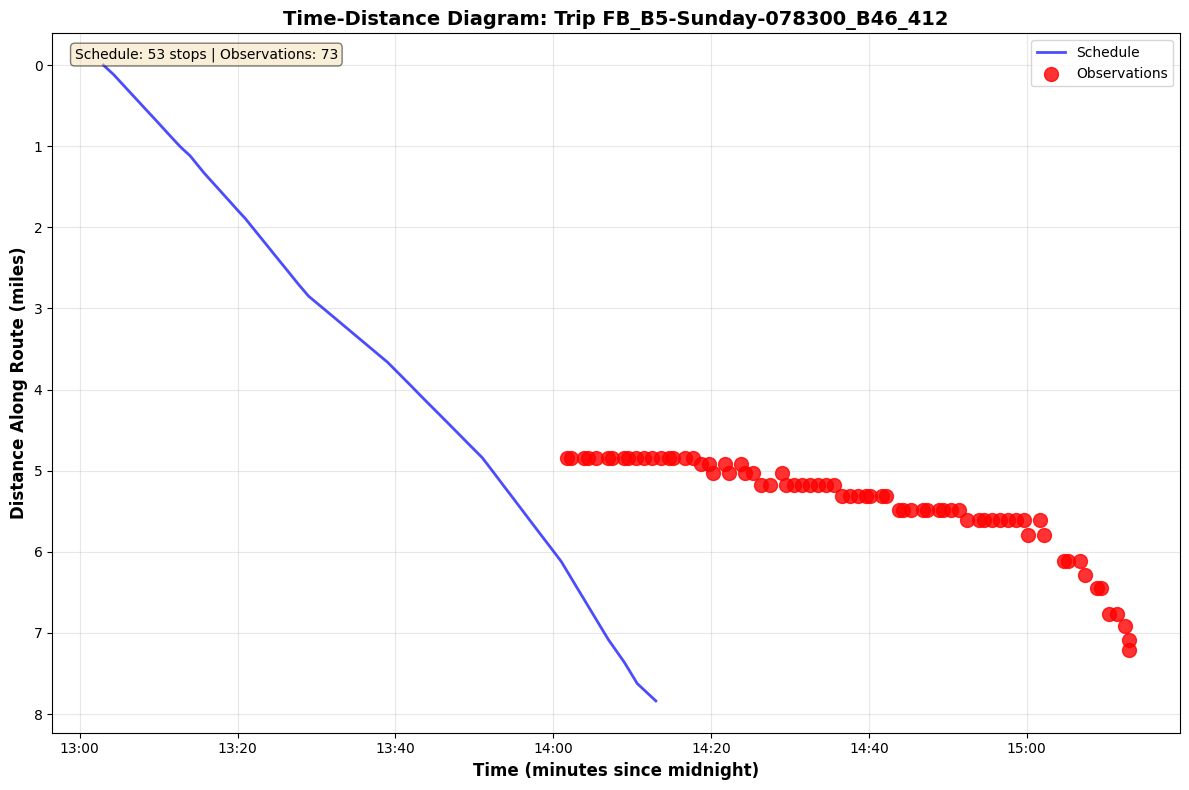

In [18]:
# Plot time-distance diagram for a single trip
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_trip_time_distance(trip_id, figsize=(12, 8)):
    """
    Plot time-distance diagram for a single trip
    - Schedule as a continuous line
    - Observations as prominent dots
    """
    # Get scheduled stops for this trip
    trip_schedule = b46_stop_times[b46_stop_times['trip_id'] == trip_id].copy()
    
    # Get observations for this trip
    trip_observations = df_b46_with_distance[
        df_b46_with_distance['vehicle.trip.trip_id'] == trip_id
    ].copy()
    
    if len(trip_schedule) == 0:
        print(f"No schedule found for trip {trip_id}")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot scheduled route as a line (time on x, distance on y)
    ax.plot(
        trip_schedule['minutes_since_midnight'],
        trip_schedule['cumulative_distance_miles'], 
        'b-', 
        linewidth=2, 
        label='Schedule',
        alpha=0.7
    )
    
    # Plot observations as dots
    if len(trip_observations) > 0:
        ax.scatter(
            trip_observations['observation_minutes'],
            trip_observations['cumulative_distance_miles'],
            c='red',
            s=100,
            alpha=0.8,
            label='Observations',
            zorder=5
        )
    
    # Formatting
    ax.set_xlabel('Time (minutes since midnight)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Distance Along Route (miles)', fontsize=12, fontweight='bold')
    ax.set_title(f'Time-Distance Diagram: Trip {trip_id}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Invert y-axis so route starts at top (distance 0)
    ax.invert_yaxis()
    
    # Format x-axis as time
    xticks = ax.get_xticks()
    xticklabels = [f"{int(t//60):02d}:{int(t%60):02d}" for t in xticks]
    ax.set_xticklabels(xticklabels)
    
    # Add info text
    info_text = f"Schedule: {len(trip_schedule)} stops | Observations: {len(trip_observations)}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig, ax

# Example: Plot a trip with good observation coverage
print("Plotting Single Trip Example")
print("="*60)

# Find a trip with good observation coverage (50+ observations)
good_trips = b46_trip_summary[b46_trip_summary['num_observations'] >= 50].head(5)
print(f"\nTrips with 50+ observations:")
print(good_trips[['trip_id', 'num_observations', 'duration_minutes']])

# Plot the first one
example_trip_id = good_trips.iloc[0]['trip_id']
print(f"\nPlotting trip: {example_trip_id}")

plot_trip_time_distance(example_trip_id)
plt.show()


Example 1: Morning Rush Hour (6 AM - 10 AM), Direction 0
Plotting 15 trips


/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/2298474196.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


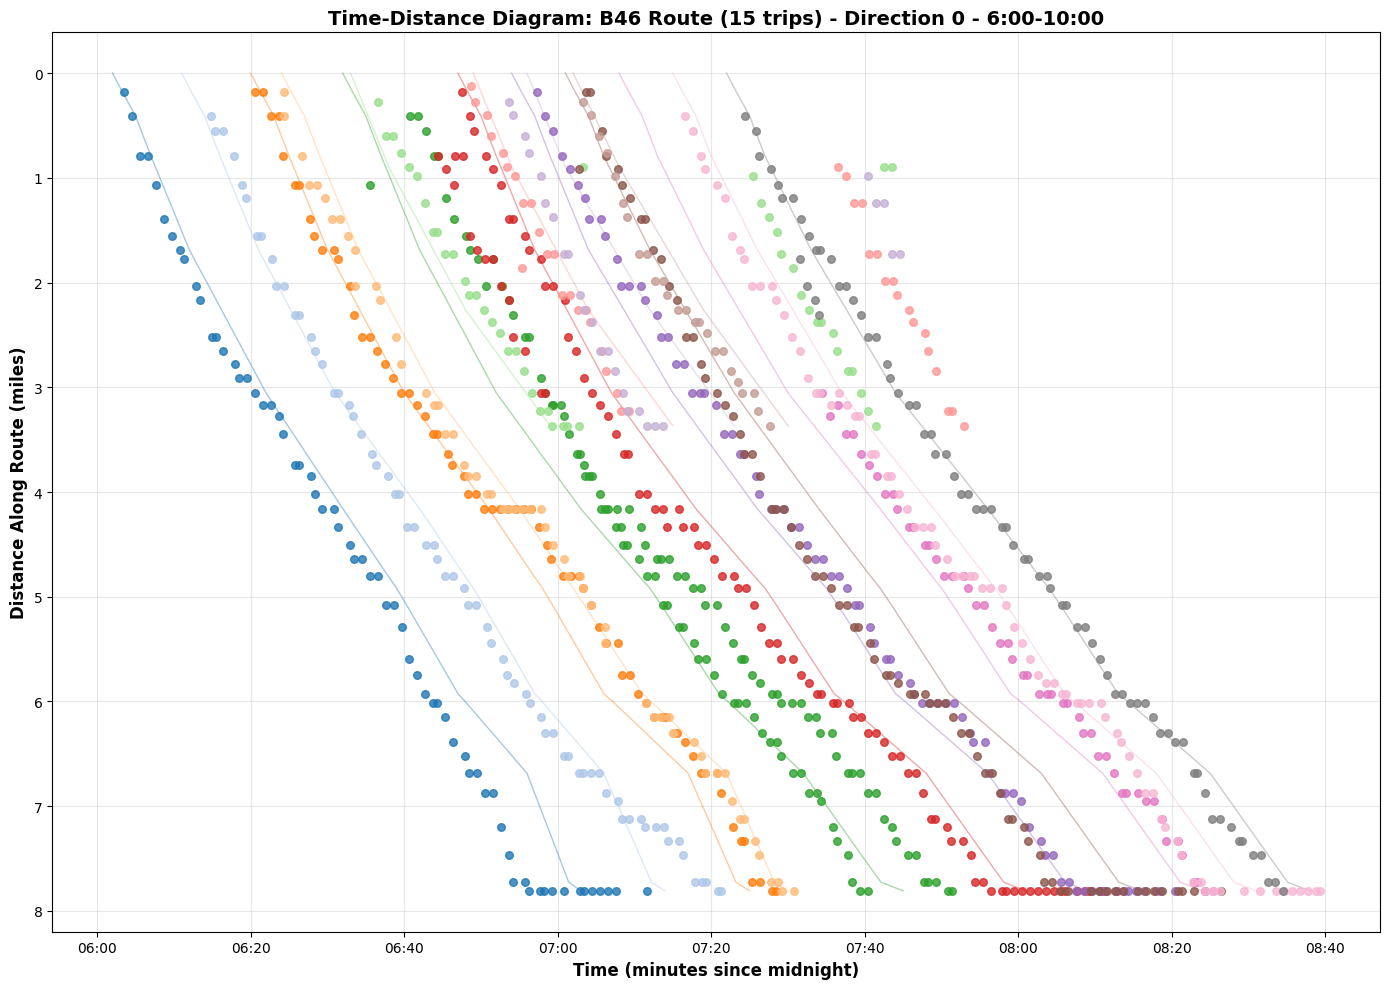

In [19]:
# Plot multiple trips on the same time-distance diagram
def plot_multiple_trips_time_distance(trip_ids=None, direction=None, time_range=None, 
                                       max_trips=20, figsize=(14, 10)):
    """
    Plot time-distance diagram for multiple trips
    - Each trip's schedule as a thin line
    - Observations as dots
    
    Parameters:
    - trip_ids: list of specific trip IDs to plot (or None to auto-select)
    - direction: 0 or 1 to filter by direction (or None for both)
    - time_range: tuple (min_hour, max_hour) to filter trips
    - max_trips: maximum number of trips to plot
    """
    
    # Select trips to plot
    if trip_ids is None:
        # Auto-select trips with good observation coverage
        trips_to_plot = b46_trip_summary[
            b46_trip_summary['num_observations'] >= 20
        ].copy()
        
        if direction is not None:
            trips_to_plot = trips_to_plot[trips_to_plot['direction_id'] == direction]
        
        # Filter by time range if specified
        if time_range is not None:
            min_hour, max_hour = time_range
            trip_schedule_times = b46_stop_times.groupby('trip_id')['minutes_since_midnight'].min()
            valid_trip_ids = trip_schedule_times[
                (trip_schedule_times >= min_hour * 60) & 
                (trip_schedule_times < max_hour * 60)
            ].index
            trips_to_plot = trips_to_plot[trips_to_plot['trip_id'].isin(valid_trip_ids)]
        
        trips_to_plot = trips_to_plot.head(max_trips)
        trip_ids = trips_to_plot['trip_id'].tolist()
    
    print(f"Plotting {len(trip_ids)} trips")
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color map for trips
    colors = plt.cm.tab20(range(len(trip_ids)))
    
    for idx, trip_id in enumerate(trip_ids):
        # Get scheduled stops for this trip
        trip_schedule = b46_stop_times[b46_stop_times['trip_id'] == trip_id].copy()
        
        # Get observations for this trip
        trip_observations = df_b46_with_distance[
            df_b46_with_distance['vehicle.trip.trip_id'] == trip_id
        ].copy()
        
        if len(trip_schedule) == 0:
            continue
        
        color = colors[idx % len(colors)]
        
        # Plot scheduled route as a thin line (time on x, distance on y)
        ax.plot(
            trip_schedule['minutes_since_midnight'],
            trip_schedule['cumulative_distance_miles'], 
            '-', 
            linewidth=1, 
            alpha=0.4,
            color=color
        )
        
        # Plot observations as dots
        if len(trip_observations) > 0:
            ax.scatter(
                trip_observations['observation_minutes'],
                trip_observations['cumulative_distance_miles'],
                c=[color],
                s=30,
                alpha=0.8,
                zorder=5
            )
    
    # Formatting
    ax.set_xlabel('Time (minutes since midnight)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Distance Along Route (miles)', fontsize=12, fontweight='bold')
    
    title = f'Time-Distance Diagram: B46 Route ({len(trip_ids)} trips)'
    if direction is not None:
        title += f' - Direction {int(direction)}'
    if time_range is not None:
        title += f' - {time_range[0]}:00-{time_range[1]}:00'
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    
    # Invert y-axis so route starts at top (distance 0)
    ax.invert_yaxis()
    
    # Format x-axis as time
    xticks = ax.get_xticks()
    xticklabels = [f"{int(t//60):02d}:{int(t%60):02d}" for t in xticks]
    ax.set_xticklabels(xticklabels)
    
    plt.tight_layout()
    return fig, ax

# Example 1: Morning rush hour, direction 0
print("\n" + "="*60)
print("Example 1: Morning Rush Hour (6 AM - 10 AM), Direction 0")
print("="*60)

plot_multiple_trips_time_distance(
    direction=0,
    time_range=(6, 10),
    max_trips=15
)
plt.show()


Example 2: Evening Service (6 PM - 10 PM), Both Directions
Plotting 20 trips


/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/2298474196.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


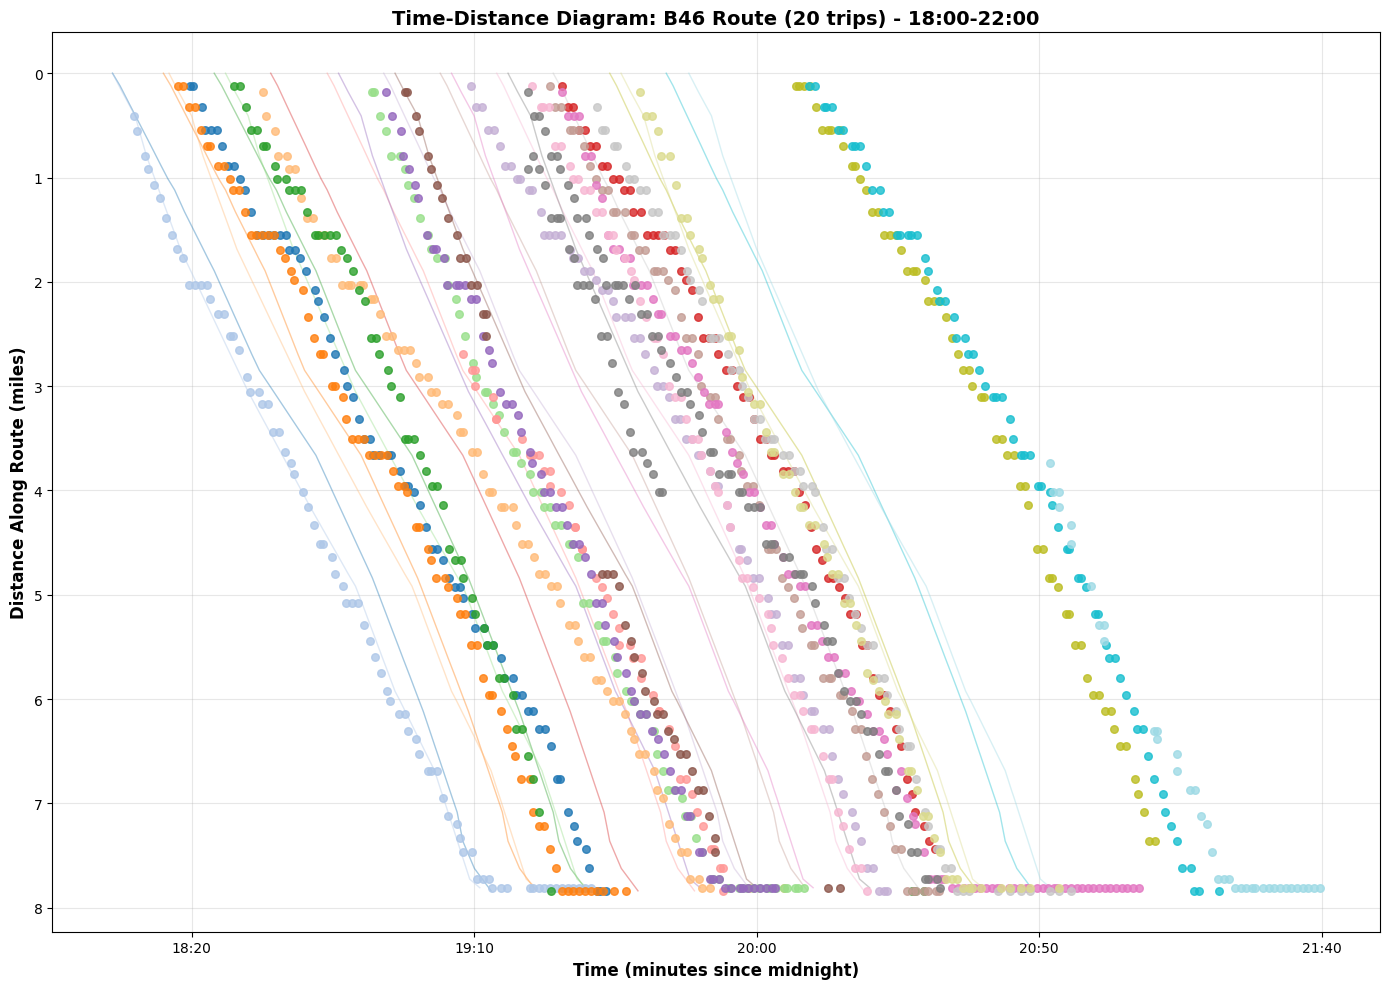

In [20]:
# Example 2: Evening service, both directions
print("\n" + "="*60)
print("Example 2: Evening Service (6 PM - 10 PM), Both Directions")
print("="*60)

plot_multiple_trips_time_distance(
    time_range=(18, 22),
    max_trips=20
)
plt.show()


Example 3: Full Day Service by Direction

Direction 0: Plotting 25 trips

Direction 1: Plotting 25 trips


/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/3180688500.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/3180688500.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/3180688500.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_xticklabels([f"{i:02d}:00" for i in range(0, 25, 4)])
/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/3180688500.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


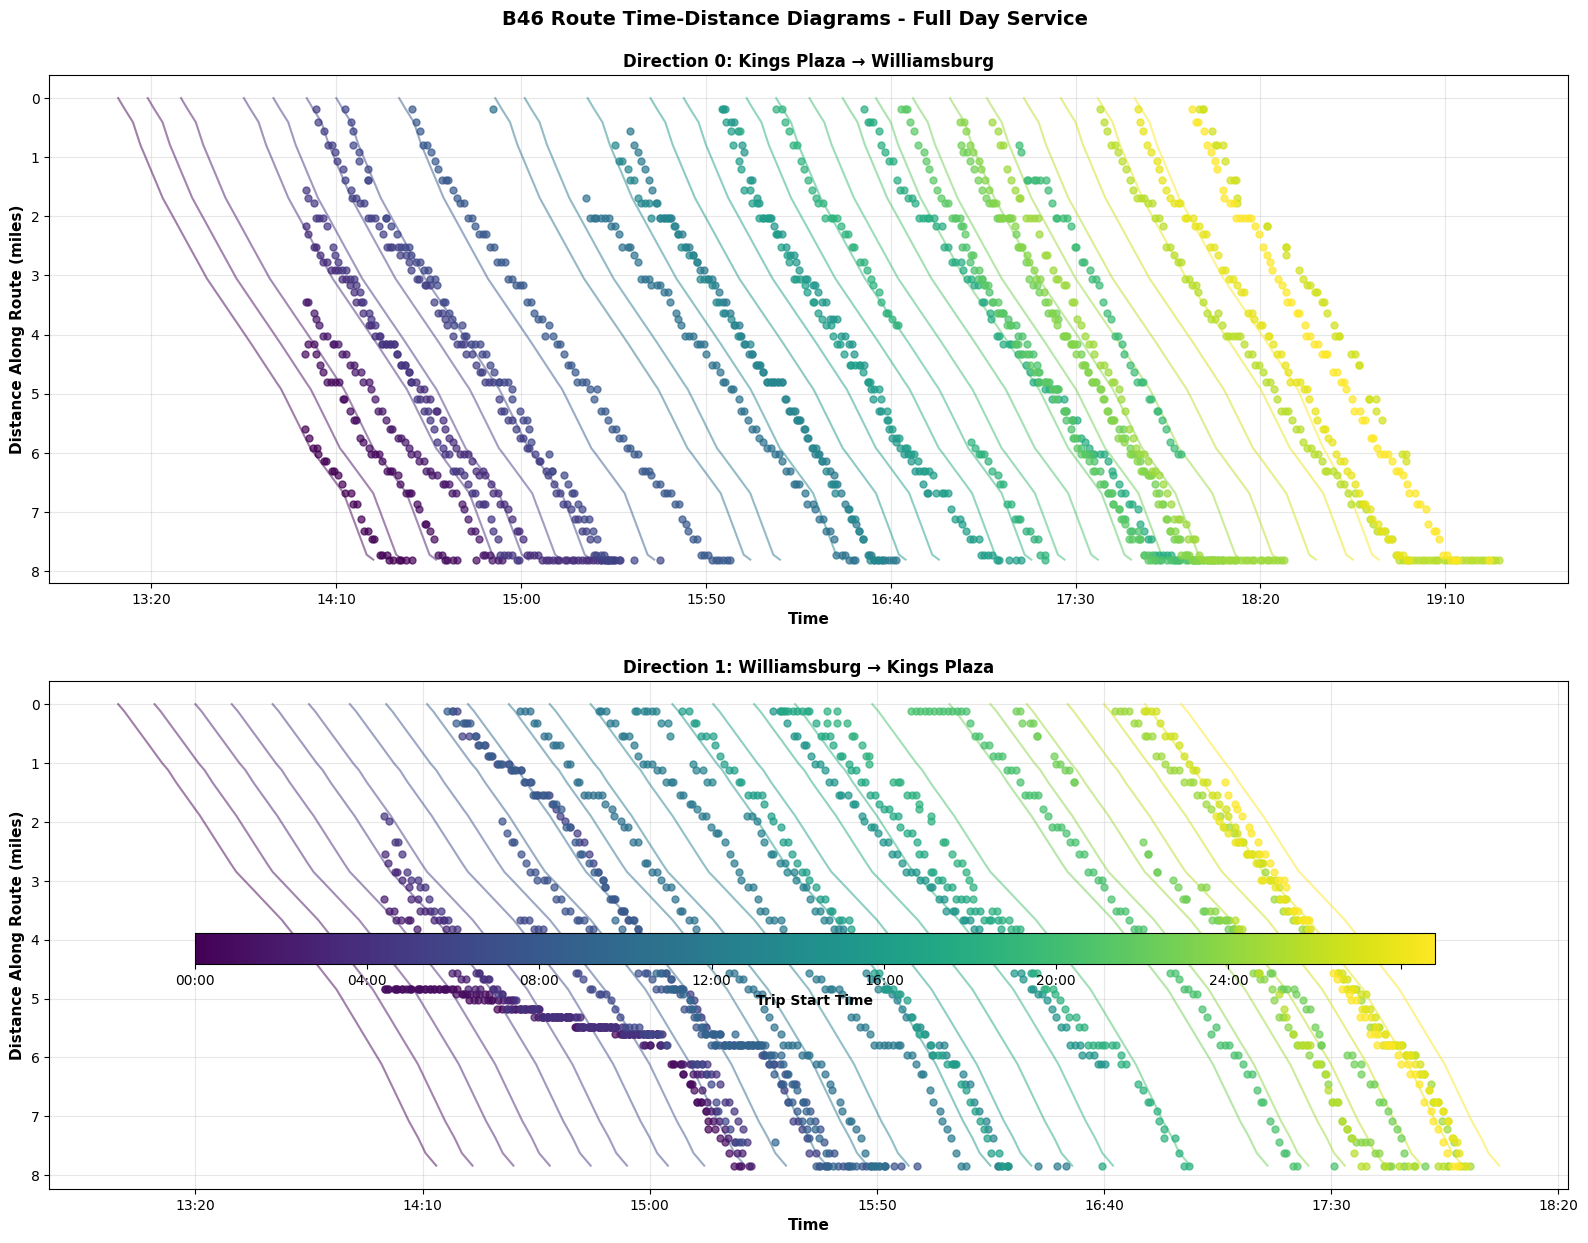


✓ Visualization complete!


In [21]:
# Create a comprehensive all-day view by direction
print("\n" + "="*60)
print("Example 3: Full Day Service by Direction")
print("="*60)

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

for direction in [0, 1]:
    ax = axes[direction]
    
    # Get trips for this direction with good coverage
    trips_to_plot = b46_trip_summary[
        (b46_trip_summary['num_observations'] >= 30) &
        (b46_trip_summary['direction_id'] == direction)
    ].head(25)
    
    trip_ids = trips_to_plot['trip_id'].tolist()
    print(f"\nDirection {direction}: Plotting {len(trip_ids)} trips")
    
    # Color by time of day
    colors = []
    for trip_id in trip_ids:
        trip_start_time = b46_stop_times[b46_stop_times['trip_id'] == trip_id]['minutes_since_midnight'].min()
        colors.append(trip_start_time)
    
    # Normalize colors to 0-1 range for colormap
    if len(colors) > 0:
        colors = np.array(colors)
        color_normalized = (colors - colors.min()) / (colors.max() - colors.min() + 0.001)
    
    for idx, trip_id in enumerate(trip_ids):
        # Get scheduled stops
        trip_schedule = b46_stop_times[b46_stop_times['trip_id'] == trip_id].copy()
        
        # Get observations
        trip_observations = df_b46_with_distance[
            df_b46_with_distance['vehicle.trip.trip_id'] == trip_id
        ].copy()
        
        if len(trip_schedule) == 0:
            continue
        
        color = plt.cm.viridis(color_normalized[idx])
        
        # Plot schedule (time on x, distance on y)
        ax.plot(
            trip_schedule['minutes_since_midnight'],
            trip_schedule['cumulative_distance_miles'], 
            '-', 
            linewidth=1.5, 
            alpha=0.5,
            color=color
        )
        
        # Plot observations
        if len(trip_observations) > 0:
            ax.scatter(
                trip_observations['observation_minutes'],
                trip_observations['cumulative_distance_miles'],
                c=[color],
                s=25,
                alpha=0.7,
                zorder=5
            )
    
    # Formatting
    ax.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax.set_ylabel('Distance Along Route (miles)', fontsize=11, fontweight='bold')
    
    direction_name = "Kings Plaza → Williamsburg" if direction == 0 else "Williamsburg → Kings Plaza"
    ax.set_title(f'Direction {direction}: {direction_name}', fontsize=12, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    
    # Invert y-axis so route starts at top (distance 0)
    ax.invert_yaxis()
    
    # Format x-axis as time
    xticks = ax.get_xticks()
    xticklabels = [f"{int(t//60):02d}:{int(t%60):02d}" for t in xticks]
    ax.set_xticklabels(xticklabels)

# Add colorbar to show time of day
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1440))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Trip Start Time', fontsize=10, fontweight='bold')
cbar.ax.set_xticklabels([f"{i:02d}:00" for i in range(0, 25, 4)])

plt.suptitle('B46 Route Time-Distance Diagrams - Full Day Service', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")


Schedule Adherence Analysis

Analyzing schedule adherence for trip: FB_B5-Sunday-078300_B46_412

Schedule Adherence Summary:
  Average deviation: 42.3 minutes
  Std deviation: 17.4 minutes
  Min (early): 10.8 minutes
  Max (late): 66.5 minutes
  On-time rate (±5 min): 0.0%


/var/folders/lq/z1mjp6ls4ds6dd2r7zcll2q00000gn/T/ipykernel_81222/2183706282.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(xticklabels)


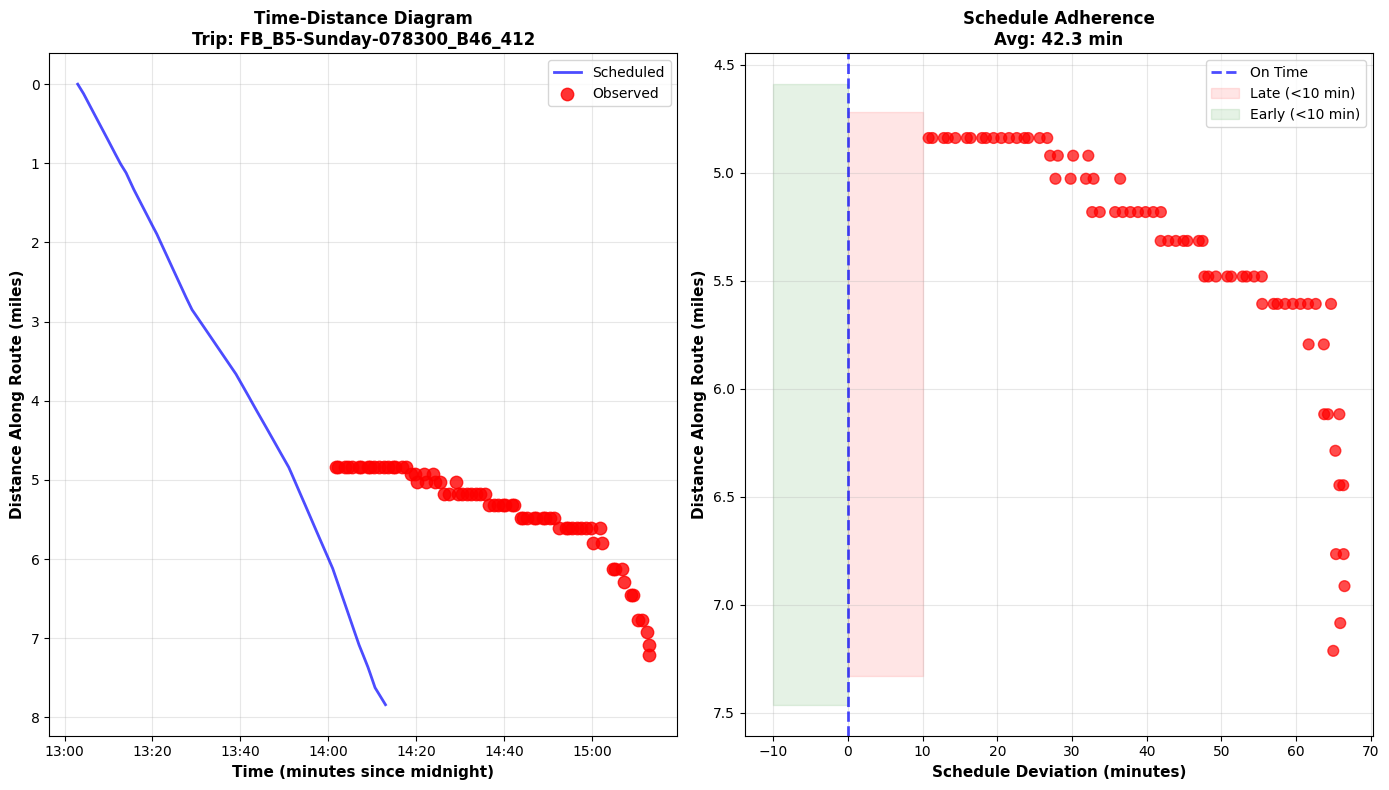

In [22]:
# Schedule adherence analysis: comparing scheduled vs observed times
print("\n" + "="*60)
print("Schedule Adherence Analysis")
print("="*60)

def plot_schedule_adherence_diagram(trip_id, figsize=(14, 8)):
    """
    Plot time-distance diagram showing schedule deviation
    - Blue line: scheduled times
    - Red dots: actual observations
    - Shaded area: early/late regions
    """
    # Get scheduled stops
    trip_schedule = b46_stop_times[b46_stop_times['trip_id'] == trip_id].copy()
    
    # Get observations
    trip_observations = df_b46_with_distance[
        df_b46_with_distance['vehicle.trip.trip_id'] == trip_id
    ].copy()
    
    if len(trip_schedule) == 0 or len(trip_observations) == 0:
        print(f"Insufficient data for trip {trip_id}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Left plot: Standard time-distance diagram (time on x, distance on y)
    ax1.plot(
        trip_schedule['minutes_since_midnight'],
        trip_schedule['cumulative_distance_miles'], 
        'b-', 
        linewidth=2, 
        label='Scheduled',
        alpha=0.7
    )
    
    ax1.scatter(
        trip_observations['observation_minutes'],
        trip_observations['cumulative_distance_miles'],
        c='red',
        s=80,
        alpha=0.8,
        label='Observed',
        zorder=5
    )
    
    ax1.set_xlabel('Time (minutes since midnight)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Distance Along Route (miles)', fontsize=11, fontweight='bold')
    ax1.set_title(f'Time-Distance Diagram\nTrip: {trip_id}', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Invert y-axis so route starts at top (distance 0)
    ax1.invert_yaxis()
    
    # Format x-axis as time
    xticks = ax1.get_xticks()
    xticklabels = [f"{int(t//60):02d}:{int(t%60):02d}" for t in xticks]
    ax1.set_xticklabels(xticklabels)
    
    # Right plot: Schedule deviation
    # Match observations to nearest scheduled stops
    schedule_deviations = []
    distances_with_deviation = []
    
    for _, obs in trip_observations.iterrows():
        obs_distance = obs['cumulative_distance_miles']
        obs_time = obs['observation_minutes']
        
        # Find the closest scheduled stop by distance
        schedule_at_distance = trip_schedule.iloc[
            (trip_schedule['cumulative_distance_miles'] - obs_distance).abs().argmin()
        ]
        
        scheduled_time = schedule_at_distance['minutes_since_midnight']
        deviation = obs_time - scheduled_time  # Positive = late, negative = early
        
        schedule_deviations.append(deviation)
        distances_with_deviation.append(obs_distance)
    
    # Plot deviation
    colors = ['red' if d > 0 else 'green' for d in schedule_deviations]
    ax2.scatter(
        schedule_deviations,
        distances_with_deviation,
        c=colors,
        s=60,
        alpha=0.7,
        zorder=5
    )
    
    # Add zero line
    ax2.axvline(x=0, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='On Time')
    
    # Shade early/late regions
    ax2.fill_betweenx(
        ax2.get_ylim(), 0, 10, alpha=0.1, color='red', label='Late (<10 min)'
    )
    ax2.fill_betweenx(
        ax2.get_ylim(), 0, -10, alpha=0.1, color='green', label='Early (<10 min)'
    )
    
    ax2.set_xlabel('Schedule Deviation (minutes)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Distance Along Route (miles)', fontsize=11, fontweight='bold')
    ax2.set_title(f'Schedule Adherence\nAvg: {np.mean(schedule_deviations):.1f} min', 
                  fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Invert y-axis so route starts at top (distance 0)
    ax2.invert_yaxis()
    
    plt.tight_layout()
    
    # Print summary stats
    print(f"\nSchedule Adherence Summary:")
    print(f"  Average deviation: {np.mean(schedule_deviations):.1f} minutes")
    print(f"  Std deviation: {np.std(schedule_deviations):.1f} minutes")
    print(f"  Min (early): {np.min(schedule_deviations):.1f} minutes")
    print(f"  Max (late): {np.max(schedule_deviations):.1f} minutes")
    print(f"  On-time rate (±5 min): {100 * np.sum(np.abs(schedule_deviations) <= 5) / len(schedule_deviations):.1f}%")
    
    return fig, (ax1, ax2)

# Plot schedule adherence for the example trip
example_trip_id = good_trips.iloc[0]['trip_id']
print(f"\nAnalyzing schedule adherence for trip: {example_trip_id}")

plot_schedule_adherence_diagram(example_trip_id)
plt.show()

---
## Summary: Time-Distance Diagrams

The time-distance diagrams (also called string diagrams or Marey diagrams) provide powerful visualizations of bus service:

**Key Features:**
- **Time on X-axis**: Time of day (hours and minutes), progressing left to right
- **Distance on Y-axis**: Cumulative distance along the route (in miles), with 0 at top (route start) and increasing downward
- **Scheduled service**: Continuous lines showing the planned route timing
- **Actual observations**: Dots showing real-time vehicle positions
- **Multiple trips**: Overlaid to show service patterns throughout the day

**What You Can See:**
1. **Service frequency**: Horizontal spacing between lines shows time between buses
2. **Schedule adherence**: Horizontal gap between line and dots shows early/late performance
3. **Travel time**: Slope of lines indicates speed (flatter = faster, steeper = slower)
4. **Bunching**: Lines converging indicate multiple buses arriving together
5. **Service gaps**: Large horizontal spacing shows time gaps between buses

**Use Cases:**
- Transit planning and analysis
- Service reliability monitoring
- Identifying bottlenecks and congestion points
- Comparing scheduled vs actual performance
- Understanding time-of-day service patterns

You can customize these plots by:
- Filtering by direction (`direction=0` or `direction=1`)
- Limiting to specific time windows (`time_range=(start_hour, end_hour)`)
- Selecting specific trips (`trip_ids=[...]`)
- Adjusting maximum trips shown (`max_trips=N`)

The schedule adherence analysis shows where buses run early, on-time, or late along the route.

**Note on Timezones:**
- GTFS schedule times are in Eastern Time (New York local time)
- Real-time observations are converted from UTC to Eastern Time for accurate comparison